In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')


In [10]:
pjme = pd.read_csv('data/PJME_hourly.csv', index_col=[0], parse_dates=[0])
pjme.head

<bound method NDFrame.head of                      PJME_MW
Datetime                    
2002-12-31 01:00:00  26498.0
2002-12-31 02:00:00  25147.0
2002-12-31 03:00:00  24574.0
2002-12-31 04:00:00  24393.0
2002-12-31 05:00:00  24860.0
...                      ...
2018-01-01 20:00:00  44284.0
2018-01-01 21:00:00  43751.0
2018-01-01 22:00:00  42402.0
2018-01-01 23:00:00  40164.0
2018-01-02 00:00:00  38608.0

[145366 rows x 1 columns]>

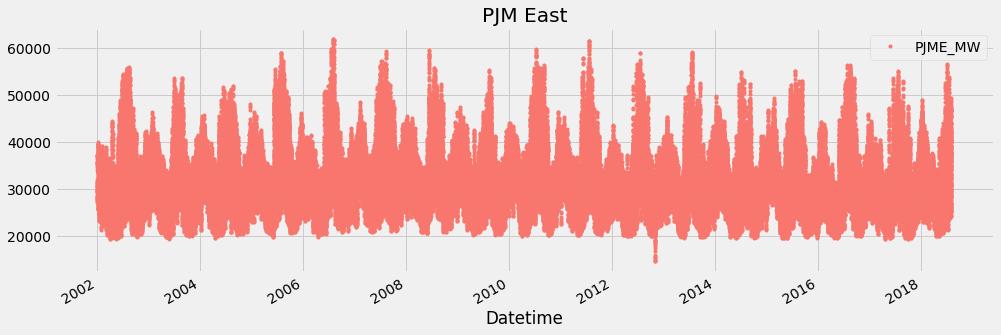

In [8]:
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
_ = pjme.plot(style='.', figsize=(15,5), color=color_pal[0], title='PJM East')

In [11]:
split_date = '01-Jan-2015'
pjme_train = pjme.loc[pjme.index <= split_date].copy()
pjme_test = pjme.loc[pjme.index > split_date].copy()

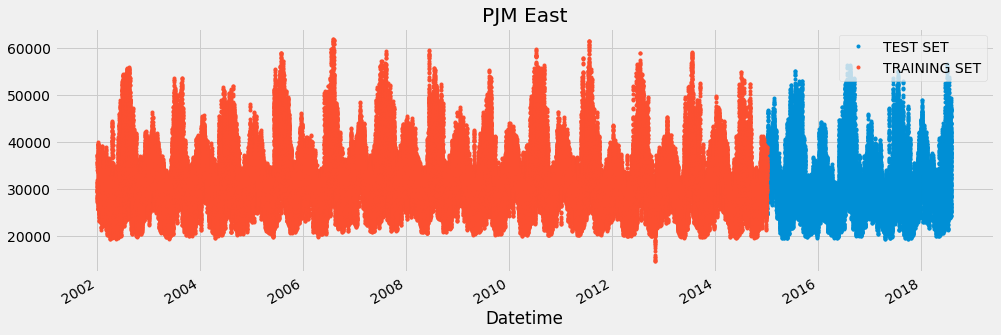

In [12]:
_ = pjme_test \
    .rename(columns={'PJME_MW': 'TEST SET'}) \
    .join(pjme_train.rename(columns={'PJME_MW': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='PJM East', style='.')


In [13]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year','dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X


In [14]:
X_train, y_train = create_features(pjme_train, label='PJME_MW')
X_test, y_test = create_features(pjme_test, label='PJME_MW')

/tmp/ipykernel_20130/4171625118.py:13: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['date'].dt.weekofyear


In [19]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50, verbose=False) # Change verbose to True if you want to see it train


[0]	validation_0-rmse:23192.06200	validation_1-rmse:22274.66915


/home/lsj/.pyenv/versions/3.8.11/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[1]	validation_0-rmse:16422.15718	validation_1-rmse:15525.66755
[2]	validation_0-rmse:11739.36722	validation_1-rmse:10989.66258
[3]	validation_0-rmse:8542.61317	validation_1-rmse:7892.59073
[4]	validation_0-rmse:6395.35741	validation_1-rmse:5904.56685
[5]	validation_0-rmse:4993.31587	validation_1-rmse:4822.39960
[6]	validation_0-rmse:4106.51334	validation_1-rmse:4249.08648
[7]	validation_0-rmse:3587.12672	validation_1-rmse:3946.07875
[8]	validation_0-rmse:3263.06197	validation_1-rmse:3822.64968
[9]	validation_0-rmse:3082.68153	validation_1-rmse:3769.57273
[10]	validation_0-rmse:2983.51794	validation_1-rmse:3736.43056
[11]	validation_0-rmse:2867.11332	validation_1-rmse:3753.34077
[12]	validation_0-rmse:2788.34947	validation_1-rmse:3792.44857
[13]	validation_0-rmse:2749.21369	validation_1-rmse:3830.48390
[14]	validation_0-rmse:2675.58311	validation_1-rmse:3839.60104
[15]	validation_0-rmse:2653.06963	validation_1-rmse:3845.69257
[16]	validation_0-rmse:2583.63422	validation_1-rmse:3884.041

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

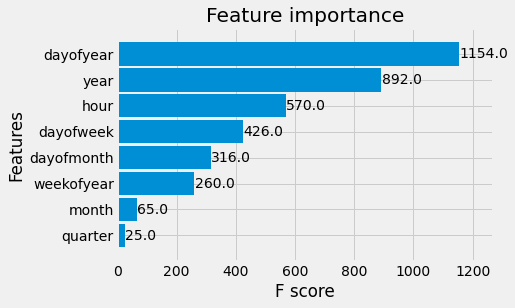

In [20]:
_ = plot_importance(reg, height=0.9)

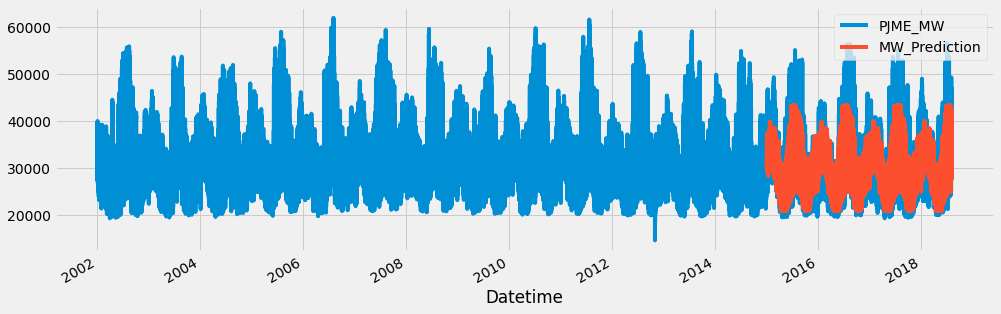

In [22]:
pjme_test['MW_Prediction'] = reg.predict(X_test)
pjme_all = pd.concat([pjme_test, pjme_train], sort=False)
_ = pjme_all[['PJME_MW','MW_Prediction']].plot(figsize=(15, 5))

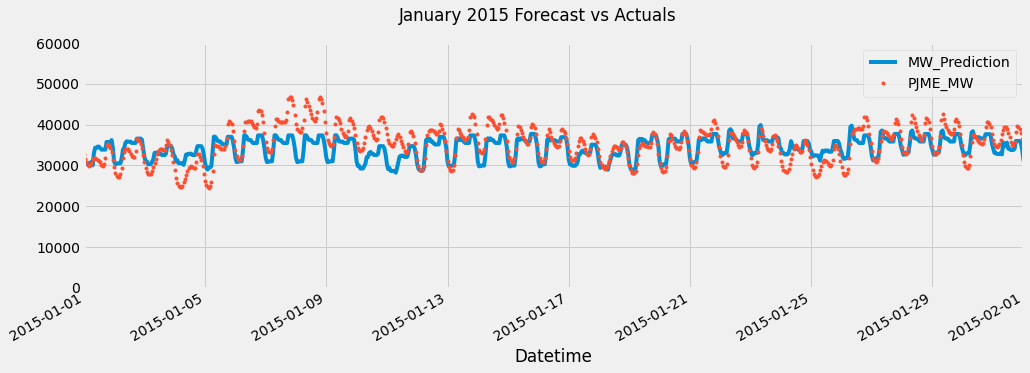

In [23]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = pjme_all[['MW_Prediction','PJME_MW']].plot(ax=ax, style=['-','.'])
ax.set_xbound(lower='01-01-2015', upper='02-01-2015')
ax.set_ylim(0, 60000)
plot = plt.suptitle('January 2015 Forecast vs Actuals')


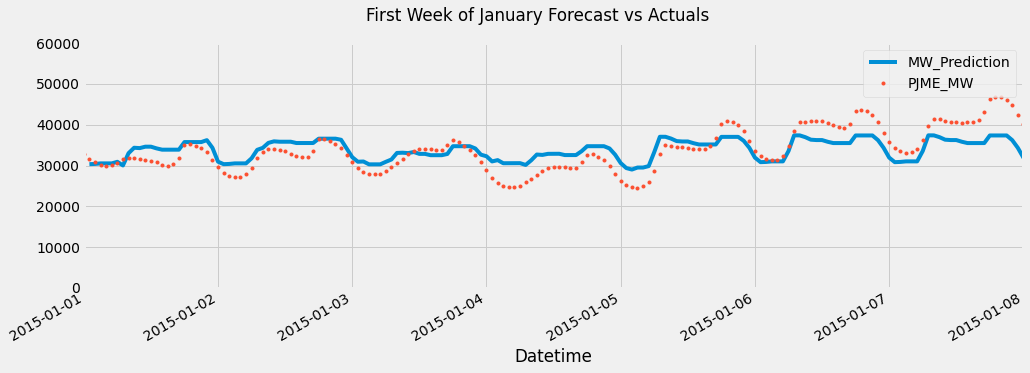

In [24]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = pjme_all[['MW_Prediction','PJME_MW']].plot(ax=ax, style=['-','.'])
ax.set_xbound(lower='01-01-2015', upper='01-08-2015')
ax.set_ylim(0, 60000)
plot = plt.suptitle('First Week of January Forecast vs Actuals')


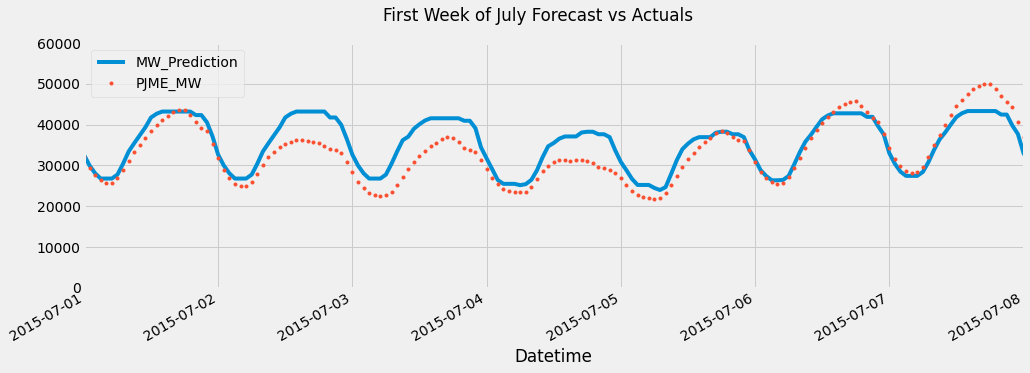

In [25]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = pjme_all[['MW_Prediction','PJME_MW']].plot(ax=ax, style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='07-01-2015', upper='07-08-2015')
plot = plt.suptitle('First Week of July Forecast vs Actuals')


In [26]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mse = mean_squared_error(y_true=pjme_test['PJME_MW'], y_pred=pjme_test['MW_Prediction'])
mae = mean_absolute_error(y_true=pjme_test['PJME_MW'], y_pred=pjme_test['MW_Prediction'])
mape = mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'], y_pred=pjme_test['MW_Prediction'])
print(f"MSE: {mse}\nMAE: {mae}\nMAPE: {mape}")


MSE: 13960913.30565261
MAE: 2757.2169004982866
MAPE: 8.510847348494002
